[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/sk-classroom/asc-transformers/blob/main/exercise/exercise_02.ipynb)

In this noteboo, we will implement attention mechanism in the foundational paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) to improve the seq2seq model. 

# Preparation


In [1]:
# If you are using Google Colab or local environments, install the following packages:
!pip install torchtext

In [2]:
# Let's import the necessary packages
import torch
import torchtext
import numpy as np
from scipy import linalg, sparse
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

# Seq2Seq w/ Attention 

## Issue of the original seq2seq 

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/b3cd54c72cd6e4e63f672d334c795b4fe744ef92//assets/seq2seq1.png)

- seq2seq has a critical information bottleneck; the encoder packs the information about the input sequence into the hidden state of the last token. 
- *Solution*: Give the decoder more information about the input sequence by using the hidden states of all tokens. 

## Attention mechanism

- **Attention** is a mechanism to determine the importance of each input token to the output token.
- For example, in machine translation, the attention mechanism will determine the importance of each word in the source language to the target word.

<div>
<img src="https://eleks.com/wp-content/uploads/bahdanau-neural-machine-translation-with-attention-mechanism.jpg" width="500px"/>
</div>

## Attention for seq2seq 


<div>
<img src="images/attention.jpg" width="80%"/>
</div>


- seq2seq with attention has a new type of vector, called *context vector*. 
- *context vector* is a weighted sum of the hidden states of the input tokens. Namely, 
$$
c_t = \sum_{i=1}^{T} a_{t,i} h^{(\ell)}_i
$$
- $t$ is the time step of the decoder, and $i$ represents the time step for the input sequence. 
- The weights $a_{t,i}$ are the *attention score* representing the importance, which is computed by
$$
a_{t,i} = \frac{\exp(\text{MLP}(s_{t-1}, h_i))}{\sum_{i=1'}^{T} \exp(\text{MLP}(s_{t-1}, h_i))}
$$ 
- $s_t$ is the state of the decoder at time $t$, and $\text{MLP}$ reppresents a neural network. 

#### Additional technical details. 

The [original paper](https://arxiv.org/abs/1409.0473) computes the hidden state by using bidirectional RNNs. 
Bidirectional RNNs consists of two RNNs. One reads a sequence in forward, and the other reads in backward. 
As a result, each token has two hidden states from the two RNNs. We will concatenate the two hidden states into a single vector, and use it as the input to the decoder. 

## Encoder 

Let's implement `Encoder` We will use *bidirectional*  ***single*** layer [Gated Recurrent Unit (GRU) by Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf). 
More specifically: 

**Step 1**: `Encoder` will take sequences of integer tokens, represented as a tensor of size <batch_size x max_length>, where `batch_size` is the number of sentences in a batch, and `max_length` is the maximum length of the sentences in the batch. 

**Step 2**: The integer tokens are mapped to the vectors of size `embedding_size` by using `torch.nn.Embedding`, namely
$$
z_t = \text{Embedding}(x_t)
$$
where $z_t$ is the vector representation of the token $x_t$. 

**Step 3**: A drop out is performed on $z_t$:

$$
z_t = \text{Dropout}(z_t)
$$

**Step 4**: Fed embedding $z_t$ into the single layer GRU.
$$
\begin{align}
h_t &= \text{GRU}(z_t, h^{(1)}_{t-1}) 
\end{align}
$$

**Step 5**: Output all the hidden states, namely 
$$
h_1, h_2, \ldots, h_T
$$



In [3]:
import torch


class Encoder(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, dropout=0.1):
        """Encoder class

        Parameters
        ----------
        input_size: int
            The number of unique tokens in the input sequence
        embedding_size: int
            The dimension of the embedding vectors
        hidden_size: int
            The dimension of the hidden states
        dropout: float
            The dropout rate
        """
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size, hidden_size)

        # TODO: Define the bidirectional GRU layer
        self.gru = torch.nn.GRU(embedding_size, hidden_size, bidirectional=True, batch_first=True)

        self.dropout = torch.nn.Dropout(dropout)

        # Initialize the embedding
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, X):
        """
        Forward pass of the encoder

        Parameters
        ----------
        X: Tensor of shape <batch_size x max_length>
            The input sequence

        Returns
        ------
        output: Tensor of shape <batch_size x max_length x hidden_size>
            The output of the encoder
        hidden: Tensor of shape <num_layers x batch_size x hidden_size>
            The hidden states of the last layer
        """
        # TODO: Implement the forward pass
        X = self.embedding(X)
        X = self.dropout(X)
        output, hidden = self.gru(X)
        
        return output, hidden
        


encoder = Encoder(input_size=30, embedding_size=16, hidden_size=56, dropout=0.1)

# test
input_tokens = torch.randint(0, 10, size=(10, 32))  # batch_size x max_length
output, hidden = encoder(input_tokens)  # batch_size x max_length x hidden_size

print(f"Shape of input_vecs: {input_tokens.shape}")
print(f"Shape of hidden: {hidden.shape}")
print(f"Shape of output: {output.shape}")

AssertionError: Padding_idx must be within num_embeddings

## Attention 

Let's implment the attention using a two-layer perceptron. 

**Step 1**: Compute the unnormalized attention scores by using 2 layer Perceptron, with ReLU activation function. 

$$
\begin{align}
z_{ti} & = [s_t, h_i] \\
z_{ti} &= \text{Linear}(z_{ti}) \\
z_{ti} &= \text{ReLu}(z_{ti}) \\
\tilde a_{t,i} &= \text{Linear}(z_{ti})
\end{align}
$$
where $s_{t}$ is the hidden state of the decoder at time $t$, and the hidden states $h_{i},\ldots,h_T$ of the encoder. 

**Step 2**: Normalize the score by using softmax, i.e., 

$$
\begin{align}
a_{t,i} = \dfrac{\exp(\tilde a_{t,i})}{\sum_{j=1}^{T} \exp(\tilde a_{t,j})} = \text{Softmax}(\tilde a_{t,i};  j=1,\ldots,T).
\end{align}
$$


In [4]:
class Attention(torch.nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, attention_hidden_size):
        """
        Attention class

        Parameters
        ----------
        encoder_hidden_size: int
            The dimension of the hidden states of the encoder
        attention_hidden_size: int
            The dimension of the hidden states of the attention
        """
        super().__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_hidden_size = attention_hidden_size
        self.softmax = torch.nn.Softmax(dim=1)

        # TODO: Define the 2 layer perceptron
        self.attn_func = torch.nn.Sequential(torch.nn.Linear((self.encoder_hidden_size+self.decoder_hidden_size), self.attention_hidden_size),
                                             torch.nn.ReLU((self.encoder_hidden_size+self.decoder_hidden_size), self.attention_hidden_size)),
                                            torch.nn.Linear((self.encoder_hidden_size+self.decoder_hidden_size), self.attention_hidden_size))

    def forward(self, hidden, encoder_outputs):
        """
        Forward pass of the attention

        Parameters
        ----------
        hidden: Tensor of shape <1 x batch_size x hidden_size>
            The hidden state of the decoder
        encoder_outputs: Tensor of shape <batch_size x src_length x hidden_size>
            The output of the encoder

        Returns
        -------
        att: Tensor of shape <batch_size x src_length>
            The attention weights
        """

        # hidden and encoder_ouputs have different dimensions.
        # - hidden is <1 x batch_size x hidden_size>
        # - encoder_outputs is <batch_size x src_length x hidden_size>
        # let's align the sizes of the two

        # TODO: Align the dimensions of hidden and encoder_outputs.
        # Hint: You will need to copy the hidden state src_length times.
        # Hint: .unsqueeze and .repeat would be useful
        hidden = hidden.squeeze(0)
        hidden = hidden.unsqueeze(1)
        hidden = hidden.repeat(1, encoder_outputs.shape[1], 1)

        # TODO: Concatenate hidden and encoder_outputs along the last dimension
        # Hint: Use torch.cat.
        z = torch.cat((hidden, encoder_hidden_size), dim=2)

        # TODO: Apply the attention function
        # Hint: z is <batch_size x src_length x hidden_size + encoder_hidden_size>
        # Hint: att should be <batch_size x src_length>
        att = self.attn_func(z)
        att = att.squeeze(2)
        att = self.softmax(att)
        return att


input_size = 30  # The number of unique tokens in the input sequence
embedding_size = 15  # The dimension of the embedding vectors
encoder_hidden_size = 64  # The dimension of the hidden states
decoder_hidden_size = 32  # The dimension of the hidden states
attention_hidden_size = 16  # The dimension of the hidden states
output_size = 8  # The number of unique tokens in the output sequence

batch_size = 32  # The batch size
src_length = 10  # The length of the input sequence

inputs, hidden, encoder_outputs = (
    torch.randint(0, 10, (batch_size, 1)),
    torch.rand(1, batch_size, decoder_hidden_size),
    torch.rand(batch_size, src_length, encoder_hidden_size),
)

attention = Attention(
    encoder_hidden_size=encoder_outputs.shape[2],
    decoder_hidden_size=decoder_hidden_size,
    attention_hidden_size=attention_hidden_size,
)
attention_weights = attention(hidden, encoder_outputs)
# Print the shape of the output attention weights
print("Shape of attention weights:", attention_weights.shape)

Shape of attention weights: torch.Size([32, 10])


## Decoder 

Let's implement `Decoder`. Following the `Encoder`, we will simplify the original implementation by using two-layer GRUs. 

Instead of giving the input 

Let's assume that the input to Decoder is $[x]$. We will use a single layer GRU. 
$$
\begin{align}
z_t &= \text{Dropout}(\text{Embedding}(x_t)) \\
c_{t} &:= \text{Attention}(s_{t-1}, h_{1}, \ldots, h_{T}) \\
s_{t} &:= \text{GRU}([z_{t}, c_t], s_{t-1}) \\
x_{t+1} &:= \text{Softmax}(\text{MLP}(h^{(\ell)}_{t+1}) / \tau)
\end{align}
$$
where 
- $\text{MLP}$ is a multi-layer perceptron that ouputs a vector of the number of unique tokens, 
- $\text{Softmax}$ is a softmax function, and 
- $\tau$ is a temperature parameter that controls the randomness of the output. 

Let's implement the Decoder as follows:
1. Use a single layer GRUs
2. Apply dropout to the input embedding vectors, $z_t$
4. The `forward` function should return the output from the MLP and hidden states. 

In [5]:
class Decoder(torch.nn.Module):

    def __init__(
        self,
        input_size,
        embedding_size,
        encoder_hidden_size,
        decoder_hidden_size,
        output_size,
        attention,  # Attention!
        dropout=0.1,
    ):
        super(Decoder, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.dropout = torch.nn.Dropout(dropout)
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        # TODO: Implement the GRU layer
        self.gru = torch.nn.GRU(embedding_size + encoder_hidden_size, decoder_hidden_size)

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(decoder_hidden_size, decoder_hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(decoder_hidden_size, output_size),
        )
        self.softmax = torch.nn.Softmax(dim=2)
        self.attention = attention

        # Initialize the embedding
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, input_tokens, hidden, encoder_outputs):
        """
        Forward pass of the decoder

        Parameters
        ----------
        input_tokens: Tensor of shape <batch_size x 1>
            The input tokens
        hidden: Tensor of shape <1 x batch_size x hidden_size>
            The hidden state of the decoder
        encoder_outputs: Tensor of shape <batch_size x src_length x hidden_size>
            The output of the encoder

        Returns
        -------
        output: Tensor of shape <batch_size x output_size>
            The output of the decoder
        hidden: Tensor of shape <1 x batch_size x hidden_size>
            The hidden state of the last layer
        """
        # TODO: Implement the forward pass


        
        return


input_size = 30
embedding_size = 15
encoder_hidden_size = 64
decoder_hidden_size = 32
attention_hidden_size = 16
output_size = 8

decoder = Decoder(
    input_size=input_size,
    embedding_size=embedding_size,
    encoder_hidden_size=encoder_hidden_size,
    decoder_hidden_size=decoder_hidden_size,
    output_size=output_size,
    dropout=0.1,
    attention=Attention(
        encoder_hidden_size=encoder_hidden_size,
        decoder_hidden_size=decoder_hidden_size,
        attention_hidden_size=attention_hidden_size,
    ),
)

batch_size = 32
src_length = 10

inputs, hidden, encoder_outputs = (
    torch.randint(0, 10, (batch_size, 1)),
    torch.rand(1, batch_size, decoder_hidden_size),
    torch.rand(batch_size, src_length, encoder_hidden_size),
)

output, hidden = decoder(inputs, hidden, encoder_outputs)

### Seq2Seq 

As is the case for the vanilla seq2seq, we will use the same `Encoder` and `Decoder`. But now Decoder will take the encoder's hidden states as the input. 


In [70]:
class Seq2Seq(torch.nn.Module):

    def __init__(self, encoder, decoder, sos_token_id, eos_token_id):
        super(Seq2Seq, self).__init__()
        self.eos_token_id = eos_token_id
        self.sos_token_id = sos_token_id
        self.encoder = encoder
        self.decoder = decoder

    def forward(
        self, input_tokens, max_output_len, temperature=1.0, teacher_forcing_prob=0.5
    ):
        """
        Forward pass of the seq2seq model

        Parameters
        ----------
        input_tokens: Tensor of shape <max_length>
            The input sequence
        max_output_len: int
            The maximum length of the output sequence

        Return
        ------
        output: Tensor of shape <batch_size x max_length x hidden_size>
            The hidden states of the last layer
        """
        encoder_outputs, encoder_hidden = self.encoder(input_tokens)

        # Concatenate the bidirectional hidden states
        encoder_hidden = torch.cat([encoder_hidden[0], encoder_hidden[1]], dim=1)
        decoder_hidden = encoder_hidden.unsqueeze(0)

        decoder_input = torch.ones((1, 1), dtype=torch.long) * self.sos_token_id
        softmax = torch.nn.Softmax(dim=0)
        generated_seqs = []
        for _ in range(max_output_len):

            output, decoder_hidden = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Sampling the next token by using softmax
            probs = softmax(output.squeeze(0) / temperature)
            decoder_input = torch.multinomial(probs, 1)[0].item()
            generated_seqs.append(decoder_input)

            if decoder_input == self.eos_token_id:
                break

            decoder_input = torch.ones((1, 1), dtype=torch.long) * decoder_input
        return generated_seqs

    def forward_train(self, input_tokens, output_tokens, teacher_forcing_prob=0.5):
        """Seq2Seq

        Parameters
        ----------
        input_tokens: Tensor of shape <batch_size x max_length>
            The input sequence
        output_tokens: Tensor of shape <batch_size x max_length>
            The output sequence

        Return
        ------
        output: Tensor of shape <batch_size x max_length-1 x output_size>
            The output sequence
        """
        encoder_outputs, encoder_hidden = self.encoder(input_tokens)

        # Concatenate the bidirectional hidden states
        encoder_hidden = torch.cat([encoder_hidden[0], encoder_hidden[1]], dim=1)
        decoder_hidden = encoder_hidden.unsqueeze(0)

        encoder_outputs = encoder_outputs.squeeze(0)
        decoder_input = output_tokens[:, 0].unsqueeze(1)
        output_list = []
        for t in range(output_tokens.shape[1] - 1):
            output, decoder_hidden = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Find the top predicted token
            top_pred = output.argmax(dim=1)

            # Determine whether to use teacher forcing or not
            is_teacher_forcing = (
                torch.rand(output_tokens.shape[0], device=output_tokens.device)
                < teacher_forcing_prob
            ).long()

            # Determine the next input token
            decoder_input = output_tokens[:, t + 1] * is_teacher_forcing + top_pred * (
                1 - is_teacher_forcing
            )
            decoder_input = decoder_input.unsqueeze(1)

            output_list.append(output)
        output = torch.stack(output_list, dim=2).permute(0, 2, 1)
        return output


input_size = 30
embedding_size = 15
encoder_hidden_size = 64
attention_hidden_size = 16
output_size = 8

encoder = Encoder(
    input_size=input_size,
    embedding_size=embedding_size,
    hidden_size=encoder_hidden_size,
    dropout=0.1,
)

encoder_hidden_size *= 2

decoder = Decoder(
    input_size=input_size,
    embedding_size=embedding_size,
    encoder_hidden_size=encoder_hidden_size,
    decoder_hidden_size=encoder_hidden_size,
    output_size=output_size,
    dropout=0.1,
    attention=Attention(
        encoder_hidden_size=encoder_hidden_size,
        decoder_hidden_size=encoder_hidden_size,
        attention_hidden_size=attention_hidden_size,
    ),
)

seq2seq = Seq2Seq(encoder, decoder, eos_token_id=1, sos_token_id=0)

inputs = torch.randint(0, 10, (1, 16))

# Inference
# input_tokens = torch.randint(0, 10, (10,), dtype=torch.long)

output_tokens = torch.randint(0, 30, (10, 20), dtype=torch.long)
input_tokens = torch.randint(0, 30, (10, 20), dtype=torch.long)
seq2seq.forward_train(input_tokens, input_tokens).shape

torch.Size([10, 19, 8])

# Validation

Let's validate the seq2seq model with Caesar cipher.
We will generate ciphered texts to train seq2seq and see if the trained seq2seq decipher the text correctly.  

In [71]:
from secretpy import Caesar, CaesarProgressive, Vigenere, alphabets as al
import random
import string
import re


def generate_random_sequences(cipher_key, cipher, n_seqs, seq_len):

    sents = []
    ciphered_sents = []
    vocab = al.ENGLISH + " "
    for _ in range(n_seqs):
        sequence = "".join(random.choices(string.ascii_lowercase, k=seq_len))
        ciphered_sequence = cipher.encrypt(sequence, cipher_key, vocab)
        # assert len(sequence) == len(ciphered_sequence)
        assert sequence == cipher.decrypt(ciphered_sequence, cipher_key, vocab)
        sents.append(sequence)
        ciphered_sents.append(ciphered_sequence)
    return ciphered_sents, sents


# cipher = CaesarProgressive()
key = "qwert"
cipher = Vigenere()
ciphered_sents, sents = generate_random_sequences(
    cipher_key=key, cipher=cipher, n_seqs=10000, seq_len=10
)

sents[:3], ciphered_sents[:3]

(['jkbpcsrgfu', 'balmwyhibg', 'vifmslsdpr'],
 ['zfffvhmkwm', 'rwpconcmsz', 'kdjckanhfj'])

Let's tokenize the sentences into integers before training the seq2seq model. 

In [72]:
from collections import defaultdict


def build_tokenizer(sents):
    vocab = sorted(list(set("".join(sents))))

    vocab.append("<sos>")  # <sos> token
    vocab.append("<eos>")  # <eos> token
    vocab.append("<unk>")  # <unk> token used to represent the unknown token

    vocab_stoi = {token: i for i, token in enumerate(vocab)}
    vocab_itos = {i: token for i, token in enumerate(vocab)}

    sos_token_id = vocab_stoi["<sos>"]
    eos_token_id = vocab_stoi["<eos>"]
    unk_token_id = vocab_stoi["<unk>"]

    # If the token is not in the vocabulary, then return the unk_token_id
    # vocab_stoi = defaultdict(lambda: unk_token_id, vocab_stoi)
    # vocab_itos = defaultdict(lambda: unk_token_id, vocab_itos)

    return {
        "stoi": vocab_stoi,
        "itos": vocab_itos,
        "sos_token_id": sos_token_id,
        "eos_token_id": eos_token_id,
        "unk_token_id": unk_token_id,
    }


def tokenize(sents, vocab):
    retval = []
    for sent in sents:
        _retval = [vocab["sos_token_id"]]
        for letter in sent:
            _retval.append(vocab["stoi"][letter])
        _retval.append(vocab["eos_token_id"])
        retval.append(_retval)

    return retval


src_vocab = build_tokenizer(ciphered_sents)
trg_vocab = build_tokenizer(sents)

src_tokenized = tokenize(ciphered_sents, src_vocab)
trg_tokenized = tokenize(sents, trg_vocab)

print(src_tokenized[1])
print(trg_tokenized[3], trg_tokenized[1])

[27, 18, 23, 16, 3, 15, 14, 3, 13, 19, 26, 28]
[26, 21, 9, 15, 9, 25, 0, 21, 22, 13, 16, 27] [26, 1, 0, 11, 12, 22, 24, 7, 8, 1, 6, 27]


Let's train! First, let's get the number of unique tokens (alphabet + special tokens) and the special tokens ids.  

In [73]:
n_src_vocab = len(src_vocab["stoi"])
n_trg_vocab = len(trg_vocab["stoi"])

src_sos_token_id = src_vocab["sos_token_id"]
src_eos_token_id = src_vocab["eos_token_id"]
trg_sos_token_id = trg_vocab["sos_token_id"]
trg_eos_token_id = trg_vocab["eos_token_id"]

Then, set up the seq2seq model.

In [74]:
input_size = n_src_vocab
embedding_size = 64
encoder_hidden_size = 64
attention_hidden_size = 64
output_size = n_trg_vocab
device = "cpu"

encoder = Encoder(
    input_size=input_size,
    embedding_size=embedding_size,
    hidden_size=encoder_hidden_size,
    dropout=0,
)

encoder_hidden_size *= 2

decoder = Decoder(
    input_size=input_size,
    embedding_size=embedding_size,
    encoder_hidden_size=encoder_hidden_size,
    decoder_hidden_size=encoder_hidden_size,
    output_size=output_size,
    dropout=0,
    attention=Attention(
        encoder_hidden_size=encoder_hidden_size,
        decoder_hidden_size=encoder_hidden_size,
        attention_hidden_size=attention_hidden_size,
    ),
)
encoder.to(device)
decoder.to(device)

seq2seq = Seq2Seq(encoder, decoder, eos_token_id=1, sos_token_id=0)

# Send to CPU/GPU
seq2seq.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30, 64)
    (gru): GRU(64, 64, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0, inplace=False)
    (embedding): Embedding(30, 64)
    (gru): GRU(192, 128, batch_first=True)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=128, out_features=29, bias=True)
    )
    (softmax): Softmax(dim=2)
    (attention): Attention(
      (attn_func): Sequential(
        (0): Linear(in_features=256, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=False)
      )
      (softmax): Softmax(dim=1)
    )
  )
)

Set up the data loader. We will exploit the fact that the sequence length is fixed. 

In [75]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(src_tokenized, dtype=torch.long),
    torch.tensor(trg_tokenized, dtype=torch.long),
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=2024, shuffle=True, drop_last=True
)

Let's train!

In [76]:
from tqdm import tqdm

loss_func = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(seq2seq.parameters(), lr=1e-3)

loss_values = []
n_epochs = 100

pbar = tqdm(total=n_epochs * len(dataloader))
seq2seq.train()
for _ in range(n_epochs):
    for src, trg in dataloader:
        optimizer.zero_grad()

        src, trg = src.to(device), trg.to(device)
        output = seq2seq.forward_train(src, trg)
        loss = 0
        for t in range(trg.shape[1] - 1):
            loss += loss_func(output[:, t, :], trg[:, t + 1])
        loss /= trg.shape[1]
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_values.append(loss)
        pbar.update(1)
        pbar.set_description(f"Loss: {loss:.4f}")

pbar.close()
seq2seq.eval()

Loss: 2.4215: 100%|██████████| 400/400 [01:18<00:00,  5.11it/s]


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30, 64)
    (gru): GRU(64, 64, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0, inplace=False)
    (embedding): Embedding(30, 64)
    (gru): GRU(192, 128, batch_first=True)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=128, out_features=29, bias=True)
    )
    (softmax): Softmax(dim=2)
    (attention): Attention(
      (attn_func): Sequential(
        (0): Linear(in_features=256, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=1, bias=False)
      )
      (softmax): Softmax(dim=1)
    )
  )
)

Text(0.5, 1.0, 'Training Loss Over Time')

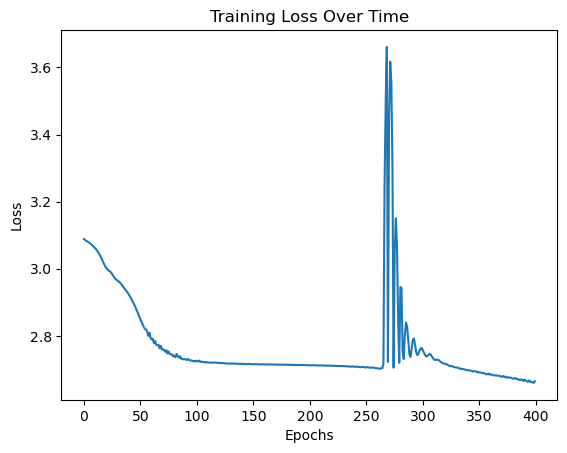

In [47]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")

Can you decipher?

In [48]:
# text = "iamastudent"
seq2seq.cpu()
for i in range(10):
    text = sents[i]
    ciphered_text = cipher.encrypt(text, key)
    ciphered_text_tokenized = torch.tensor(tokenize([ciphered_text], src_vocab))
    seqs = seq2seq(ciphered_text_tokenized, max_output_len=10, temperature=0.001)

    deciphered_text = "".join([trg_vocab["itos"][i] for i in seqs])

    print("Original-Deciphered:", text, " <--> ", deciphered_text)

Original-Deciphered: fwohykdpsf  <-->  jxoooooor<eos>
Original-Deciphered: ppgwskodak  <-->  lehooooor<eos>
Original-Deciphered: buslnhfcdv  <-->  vaaxkkkkk<eos>
Original-Deciphered: yzfpqyopkk  <-->  llooupprr<eos>
Original-Deciphered: lenljzllno  <-->  lekkkkkkb
Original-Deciphered: lsnwdyyedh  <-->  lzkkkkkkk<eos>
Original-Deciphered: pongbynhyx  <-->  b
Original-Deciphered: gsspvnovvx  <-->  aaarppprr<eos>
Original-Deciphered: nufjjyxpww  <-->  vvxxkkkkk<eos>
Original-Deciphered: syfyrfdkeb  <-->  eeekkkkkk<eos>
